In time step 0, 2 new satellites were launched, total nodes = 1010 

In time step 5, 2 new satellites were launched, total nodes = 1049 

In time step 10, 2 new satellites were launched, total nodes = 1090 

In time step 15, 2 new satellites were launched, total nodes = 1146 

In time step 20, 2 new satellites were launched, total nodes = 1188 

In time step 25, 2 new satellites were launched, total nodes = 1253 

In time step 30, 2 new satellites were launched, total nodes = 1326 

In time step 35, 2 new satellites were launched, total nodes = 1405 

In time step 40, 2 new satellites were launched, total nodes = 1499 

In time step 45, 2 new satellites were launched, total nodes = 1619 

In time step 50, 2 new satellites were launched, total nodes = 1733 

In time step 55, 2 new satellites were launched, total nodes = 1863 

In time step 60, 2 new satellites were launched, total nodes = 2009 

In time step 65, 2 new satellites were launched, total nodes = 2171 

In time step 70, 2 new

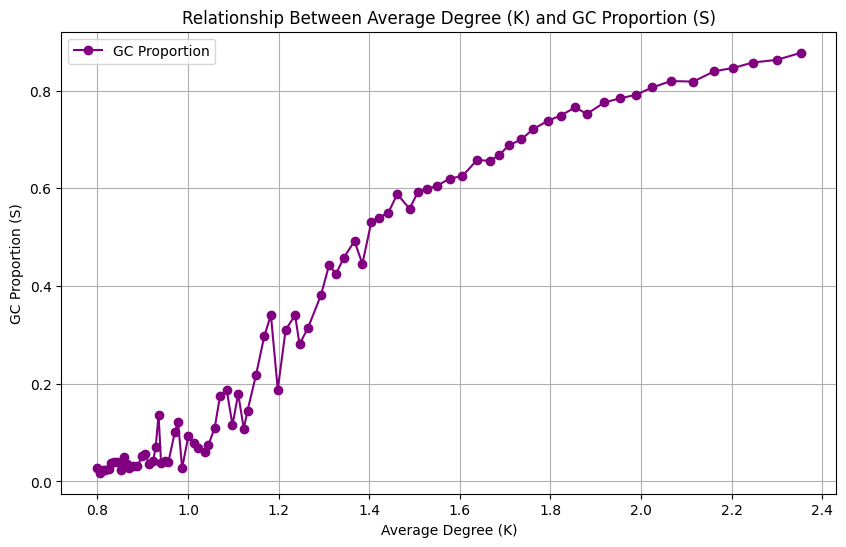

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from network.network import dynamic_network_model

# initial parameters
N = 1000  # nodes
P = 0.0008  # collision probability
plow = 0.01 # probability of generating new fragments
new_fragments_per_collision = 2  # debris per collision 
iterations = 100  # number of iterations, time steps
launch_freq = 5 # determines after how many timesteps a satellite is launched
nr_sat_launches = 2 # number of satellites launched

# # genreate a probability list from 0.001 to 0.0009
# probabilities = np.linspace(0.0001, 0.0009, 10)

# # static data
# static_network_model(N, probabilities)

# dynamic network over time
# Initialize the network
G = nx.empty_graph(N)
avg_degrees, gc_proportions, satellites_launched = dynamic_network_model(
    G, iterations, P, plow, new_fragments_per_collision, nr_sat_launches, launch_freq)

print(len(satellites_launched))
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(avg_degrees, gc_proportions, marker='o', color='purple', label='GC Proportion')
plt.title("Relationship Between Average Degree (K) and GC Proportion (S)")
plt.xlabel("Average Degree (K)")
plt.ylabel("GC Proportion (S)")
plt.grid(True)
plt.legend()
plt.show()


Running simulation 1/10...
In time step 0, 2 new satellites were launched, total nodes = 1012 

In time step 5, 2 new satellites were launched, total nodes = 1052 

In time step 10, 2 new satellites were launched, total nodes = 1110 

In time step 15, 2 new satellites were launched, total nodes = 1173 

In time step 20, 2 new satellites were launched, total nodes = 1230 

In time step 25, 2 new satellites were launched, total nodes = 1294 

In time step 30, 2 new satellites were launched, total nodes = 1372 

In time step 35, 2 new satellites were launched, total nodes = 1467 

In time step 40, 2 new satellites were launched, total nodes = 1550 

In time step 45, 2 new satellites were launched, total nodes = 1651 

In time step 50, 2 new satellites were launched, total nodes = 1762 

In time step 55, 2 new satellites were launched, total nodes = 1890 

In time step 60, 2 new satellites were launched, total nodes = 2047 

In time step 65, 2 new satellites were launched, total nodes = 22

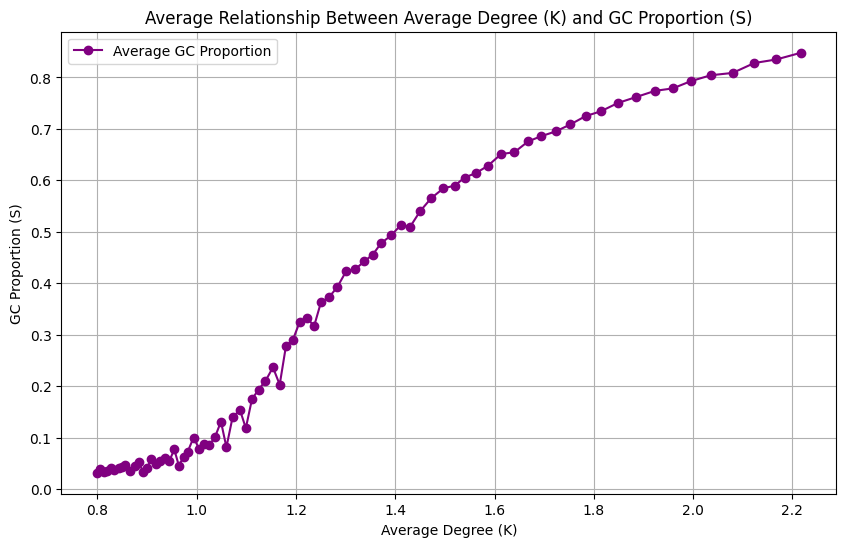

In [8]:
import matplotlib.pyplot as plt
from network.network import dynamic_network_model
import networkx as nx
import numpy as np

# Parameters
N = 1000  # Initial number of nodes
P = 0.0008  # Collision probability
plow = 0.01  # Probability of generating new fragments
new_fragments_per_collision = 2  # Debris per collision
iterations = 100  # Number of time steps
launch_freq = 5  # Launch satellites every 5 time steps
nr_sat_launches = 2  # Number of satellites launched per launch
num_simulations = 10  # Number of simulations to run

# Initialize lists to collect results across simulations
all_avg_degrees = []
all_gc_proportions = []

for sim in range(num_simulations):
    print(f"Running simulation {sim + 1}/{num_simulations}...")
    
    # Initialize the network for each simulation
    G = nx.empty_graph(N)
    
    # Run the simulation
    avg_degrees, gc_proportions, satellites_launched = dynamic_network_model(
        G, iterations, P, plow, new_fragments_per_collision, nr_sat_launches, launch_freq)
    
    # Truncate or pad to ensure consistent length
    min_length = min(len(avg_degrees), len(gc_proportions), iterations)
    avg_degrees = avg_degrees[:min_length]
    gc_proportions = gc_proportions[:min_length]
    
    # Append results (padded or truncated)
    all_avg_degrees.append(avg_degrees)
    all_gc_proportions.append(gc_proportions)

# Convert lists to numpy arrays and pad to the maximum length
max_length = min([len(seq) for seq in all_avg_degrees])
all_avg_degrees = np.array([seq[:max_length] for seq in all_avg_degrees])
all_gc_proportions = np.array([seq[:max_length] for seq in all_gc_proportions])

# Compute the average values across simulations
average_degrees = np.mean(all_avg_degrees, axis=0)
average_gc_proportions = np.mean(all_gc_proportions, axis=0)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(average_degrees, average_gc_proportions, marker='o', color='purple', label='Average GC Proportion')
plt.title("Average Relationship Between Average Degree (K) and GC Proportion (S)")
plt.xlabel("Average Degree (K)")
plt.ylabel("GC Proportion (S)")
plt.grid(True)
plt.legend()
plt.show()


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     1018.
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           5.43e-48
Time:                        17:06:08   Log-Likelihood:                 60.838
No. Observations:                  84   AIC:                            -117.7
Df Residuals:                      82   BIC:                            -112.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5666      0.027     20.923      0.0

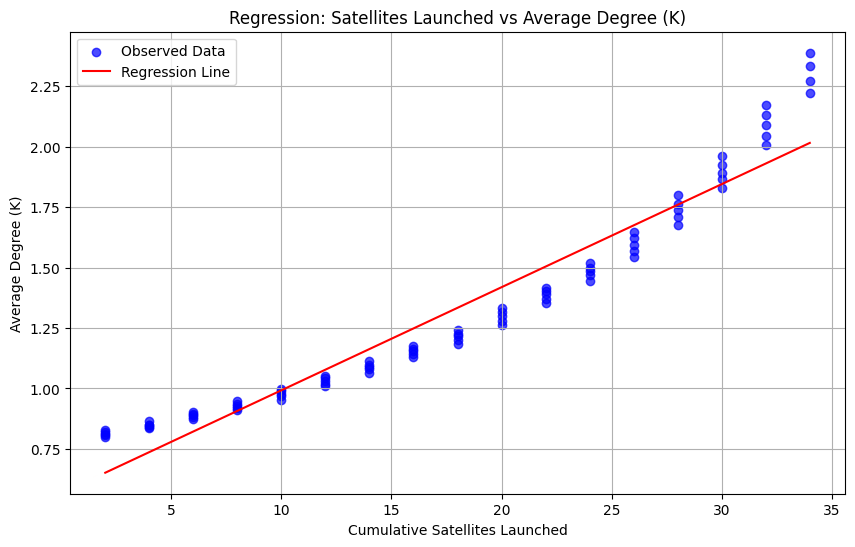

In [9]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for regression
X = np.array(satellites_launched)  # Independent variable: Cumulative Satellites Launched
y = np.array(avg_degrees)  # Dependent variable: Average Degree (K)

# Add a constant to the independent variable for the intercept
X_sm = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X_sm).fit()

# Print the regression summary
print(model.summary())

# Predicted values
y_pred = model.predict(X_sm)

# Visualize the regression
plt.figure(figsize=(10, 6))
plt.scatter(satellites_launched, avg_degrees, color='blue', alpha=0.7, label='Observed Data')
plt.plot(satellites_launched, y_pred, color='red', label='Regression Line')
plt.title("Regression: Satellites Launched vs Average Degree (K)")
plt.xlabel("Cumulative Satellites Launched")
plt.ylabel("Average Degree (K)")
plt.grid(True)
plt.legend()
plt.show()


Running dynamic network model WITHOUT satellite launches...
In time step 0, 0 new satellites were launched, total nodes = 1009 

In time step 5, 0 new satellites were launched, total nodes = 1059 

In time step 10, 0 new satellites were launched, total nodes = 1111 

In time step 15, 0 new satellites were launched, total nodes = 1174 

In time step 20, 0 new satellites were launched, total nodes = 1227 

In time step 25, 0 new satellites were launched, total nodes = 1295 

In time step 30, 0 new satellites were launched, total nodes = 1370 

In time step 35, 0 new satellites were launched, total nodes = 1451 

In time step 40, 0 new satellites were launched, total nodes = 1557 

In time step 45, 0 new satellites were launched, total nodes = 1637 

In time step 50, 0 new satellites were launched, total nodes = 1761 

In time step 55, 0 new satellites were launched, total nodes = 1896 

In time step 60, 0 new satellites were launched, total nodes = 2072 

In time step 65, 0 new satellite

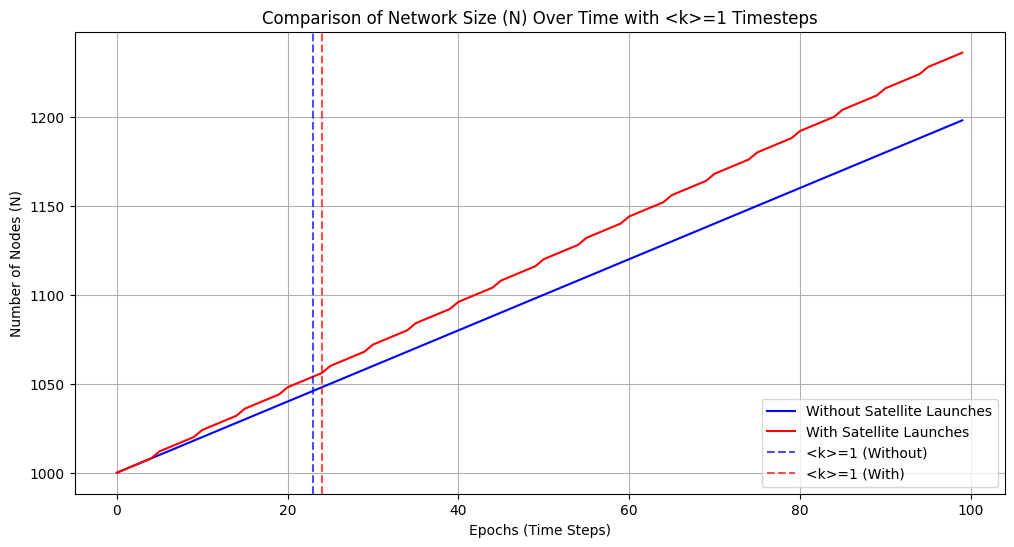

In [5]:
import matplotlib.pyplot as plt
from network.network import dynamic_network_model
import networkx as nx
import numpy as np

# Parameters
N = 1000  # Initial number of nodes
P = 0.0008  # Collision probability
plow = 0.01  # Probability of generating new fragments
new_fragments_per_collision = 2  # Debris per collision
iterations = 100  # Number of time steps
launch_freq = 5  # Launch satellites every 5 time steps
nr_sat_launches = 2  # Number of satellites launched per launch

# Initialize the networks
G_without_sat = nx.empty_graph(N)  # Without satellite launches
G_with_sat = nx.empty_graph(N)  # With satellite launches

# Run the dynamic network model WITHOUT satellite launches
print("Running dynamic network model WITHOUT satellite launches...")
avg_degrees_without, _, satellites_launched_without = dynamic_network_model(
    G_without_sat, iterations, P, plow, new_fragments_per_collision, nr_sat_launches=0, launch_freq=launch_freq
)

# Track the number of nodes over time for the model without satellite launches
nodes_over_time_without = [N + i * new_fragments_per_collision for i in range(iterations)]

# Find the timestep where <k> = 1 for without satellite launches
k_equal_1_timestep_without = next((i for i, k in enumerate(avg_degrees_without) if k >= 1), None)

# Run the dynamic network model WITH satellite launches
print("Running dynamic network model WITH satellite launches...")
avg_degrees_with, _, satellites_launched_with = dynamic_network_model(
    G_with_sat, iterations, P, plow, new_fragments_per_collision, nr_sat_launches, launch_freq
)

# Track the number of nodes over time for the model with satellite launches
nodes_over_time_with = [
    N + i * new_fragments_per_collision + (i // launch_freq) * nr_sat_launches for i in range(iterations)
]

# Find the timestep where <k> = 1 for with satellite launches
k_equal_1_timestep_with = next((i for i, k in enumerate(avg_degrees_with) if k >= 1), None)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot nodes over time for both models
plt.plot(range(iterations), nodes_over_time_without, label="Without Satellite Launches", color="blue")
plt.plot(range(iterations), nodes_over_time_with, label="With Satellite Launches", color="red")

# Add horizontal lines for <k> = 1 timesteps
if k_equal_1_timestep_without is not None:
    plt.axvline(x=k_equal_1_timestep_without, color="blue", linestyle="--", alpha=0.7, label="<k>=1 (Without)")
if k_equal_1_timestep_with is not None:
    plt.axvline(x=k_equal_1_timestep_with, color="red", linestyle="--", alpha=0.7, label="<k>=1 (With)")

# Add labels, legend, and title
plt.title("Comparison of Network Size (N) Over Time with <k>=1 Timesteps")
plt.xlabel("Epochs (Time Steps)")
plt.ylabel("Number of Nodes (N)")
plt.legend()
plt.grid(True)
plt.show()


Running simulations WITHOUT satellite launches...
In time step 0, 0 new satellites were launched, total nodes = 1006 

In time step 5, 0 new satellites were launched, total nodes = 1059 

In time step 10, 0 new satellites were launched, total nodes = 1107 

In time step 15, 0 new satellites were launched, total nodes = 1160 

In time step 20, 0 new satellites were launched, total nodes = 1220 

In time step 25, 0 new satellites were launched, total nodes = 1273 

In time step 30, 0 new satellites were launched, total nodes = 1331 

In time step 35, 0 new satellites were launched, total nodes = 1414 

In time step 40, 0 new satellites were launched, total nodes = 1501 

In time step 45, 0 new satellites were launched, total nodes = 1591 

In time step 50, 0 new satellites were launched, total nodes = 1715 

In time step 55, 0 new satellites were launched, total nodes = 1835 

In time step 60, 0 new satellites were launched, total nodes = 1963 

In time step 65, 0 new satellites were lau

/var/folders/sq/c9xq2zk97n3cf_nqf5x49c0w0000gn/T/ipykernel_43214/1655932432.py:49: RuntimeWarning: Mean of empty slice
  avg_k_without = np.nanmean(avg_degrees_without_all, axis=0)
/var/folders/sq/c9xq2zk97n3cf_nqf5x49c0w0000gn/T/ipykernel_43214/1655932432.py:50: RuntimeWarning: Mean of empty slice
  avg_k_with = np.nanmean(avg_degrees_with_all, axis=0)


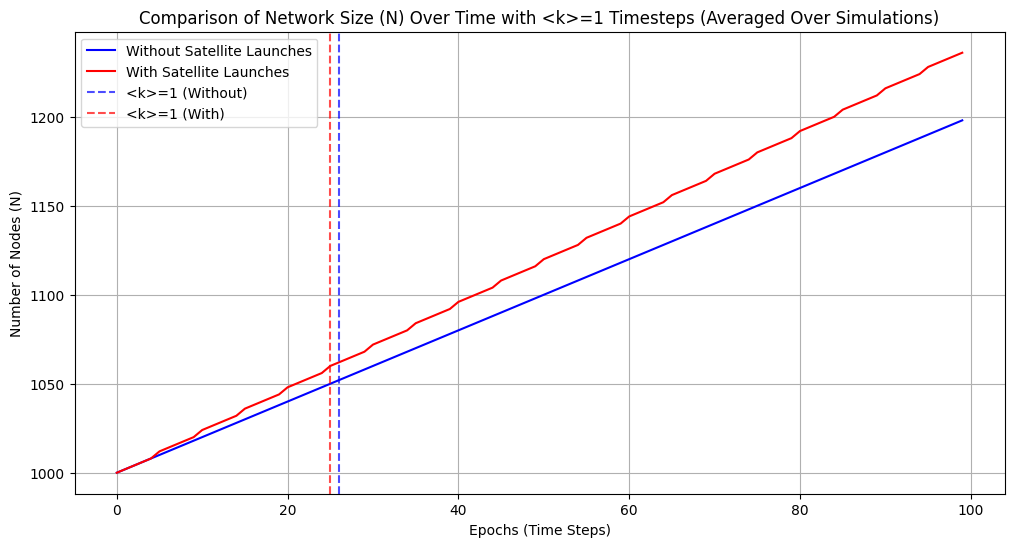

In [8]:
import matplotlib.pyplot as plt
from network.network import dynamic_network_model
import networkx as nx
import numpy as np

# Parameters
N = 1000  # Initial number of nodes
P = 0.0008  # Collision probability
plow = 0.01  # Probability of generating new fragments
new_fragments_per_collision = 2  # Debris per collision
iterations = 100  # Number of time steps
launch_freq = 5  # Launch satellites every 5 time steps
nr_sat_launches = 2  # Number of satellites launched per launch
num_simulations = 10  # Number of simulations to average

# Initialize arrays to store results across simulations
nodes_over_time_without_all = []
nodes_over_time_with_all = []
avg_degrees_without_all = []
avg_degrees_with_all = []

# Run simulations without satellite launches
print("Running simulations WITHOUT satellite launches...")
for _ in range(num_simulations):
    G_without_sat = nx.empty_graph(N)
    avg_degrees_without, _, _ = dynamic_network_model(
        G_without_sat, iterations, P, plow, new_fragments_per_collision, nr_sat_launches=0, launch_freq=launch_freq
    )
    avg_degrees_without_all.append(np.pad(avg_degrees_without, (0, iterations - len(avg_degrees_without)), constant_values=np.nan))
    nodes_over_time_without = [N + i * new_fragments_per_collision for i in range(iterations)]
    nodes_over_time_without_all.append(nodes_over_time_without)

# Run simulations with satellite launches
print("Running simulations WITH satellite launches...")
for _ in range(num_simulations):
    G_with_sat = nx.empty_graph(N)
    avg_degrees_with, _, _ = dynamic_network_model(
        G_with_sat, iterations, P, plow, new_fragments_per_collision, nr_sat_launches, launch_freq
    )
    avg_degrees_with_all.append(np.pad(avg_degrees_with, (0, iterations - len(avg_degrees_with)), constant_values=np.nan))
    nodes_over_time_with = [
        N + i * new_fragments_per_collision + (i // launch_freq) * nr_sat_launches for i in range(iterations)
    ]
    nodes_over_time_with_all.append(nodes_over_time_with)

# Compute averages across simulations
avg_nodes_without = np.nanmean(nodes_over_time_without_all, axis=0)
avg_nodes_with = np.nanmean(nodes_over_time_with_all, axis=0)
avg_k_without = np.nanmean(avg_degrees_without_all, axis=0)
avg_k_with = np.nanmean(avg_degrees_with_all, axis=0)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot nodes over time for both models
plt.plot(range(iterations), avg_nodes_without, label="Without Satellite Launches", color="blue")
plt.plot(range(iterations), avg_nodes_with, label="With Satellite Launches", color="red")

# Add horizontal lines for <k> = 1 timesteps
k_equal_1_timestep_without = next((i for i, k in enumerate(avg_k_without) if k >= 1), None)
k_equal_1_timestep_with = next((i for i, k in enumerate(avg_k_with) if k >= 1), None)
if k_equal_1_timestep_without is not None:
    plt.axvline(x=k_equal_1_timestep_without, color="blue", linestyle="--", alpha=0.7, label="<k>=1 (Without)")
if k_equal_1_timestep_with is not None:
    plt.axvline(x=k_equal_1_timestep_with, color="red", linestyle="--", alpha=0.7, label="<k>=1 (With)")

# Add labels, legend, and title
plt.title("Comparison of Network Size (N) Over Time with <k>=1 Timesteps (Averaged Over Simulations)")
plt.xlabel("Epochs (Time Steps)")
plt.ylabel("Number of Nodes (N)")
plt.legend()
plt.grid(True)
plt.show()


Running simulations WITHOUT satellite launches...
In time step 0, 0 new satellites were launched, total nodes = 1005 

In time step 5, 0 new satellites were launched, total nodes = 1046 

In time step 10, 0 new satellites were launched, total nodes = 1095 

In time step 15, 0 new satellites were launched, total nodes = 1143 

In time step 20, 0 new satellites were launched, total nodes = 1204 

In time step 25, 0 new satellites were launched, total nodes = 1256 

In time step 30, 0 new satellites were launched, total nodes = 1316 

In time step 35, 0 new satellites were launched, total nodes = 1390 

In time step 40, 0 new satellites were launched, total nodes = 1465 

In time step 45, 0 new satellites were launched, total nodes = 1549 

In time step 50, 0 new satellites were launched, total nodes = 1647 

In time step 55, 0 new satellites were launched, total nodes = 1776 

In time step 60, 0 new satellites were launched, total nodes = 1906 

In time step 65, 0 new satellites were lau

/var/folders/sq/c9xq2zk97n3cf_nqf5x49c0w0000gn/T/ipykernel_43214/2619770133.py:53: RuntimeWarning: Mean of empty slice
  avg_k_without = np.nanmean(avg_degrees_without_all, axis=0)
/var/folders/sq/c9xq2zk97n3cf_nqf5x49c0w0000gn/T/ipykernel_43214/2619770133.py:54: RuntimeWarning: Mean of empty slice
  avg_k_with = np.nanmean(avg_degrees_with_all, axis=0)
/var/folders/sq/c9xq2zk97n3cf_nqf5x49c0w0000gn/T/ipykernel_43214/2619770133.py:55: RuntimeWarning: Mean of empty slice
  avg_gc_proportions_without = np.nanmean(gc_proportions_without_all, axis=0)
/var/folders/sq/c9xq2zk97n3cf_nqf5x49c0w0000gn/T/ipykernel_43214/2619770133.py:56: RuntimeWarning: Mean of empty slice
  avg_gc_proportions_with = np.nanmean(gc_proportions_with_all, axis=0)


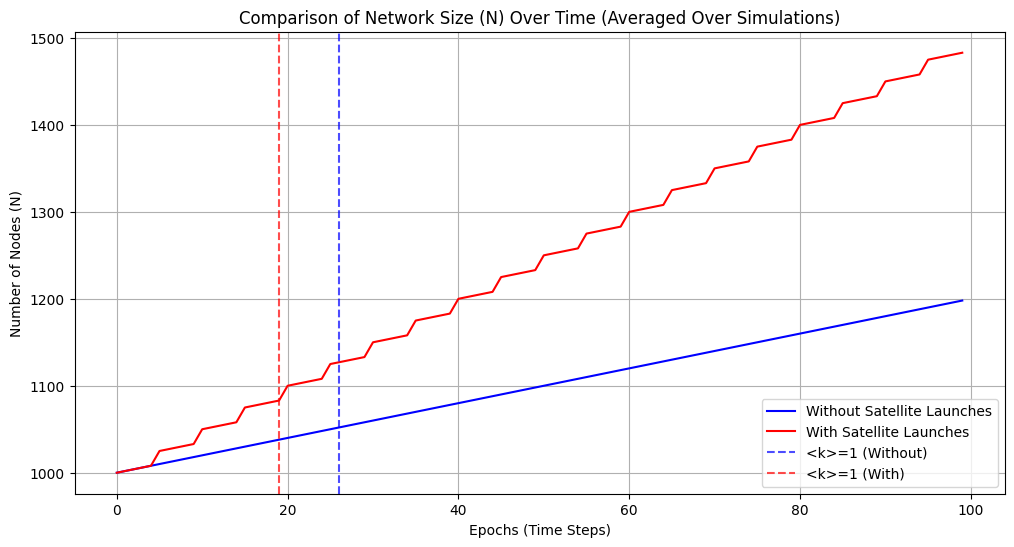

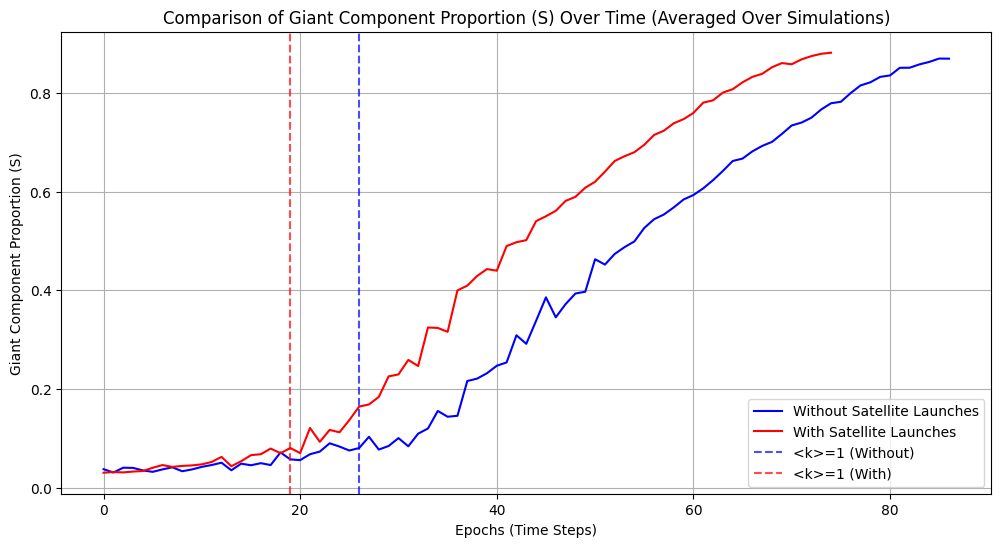

In [15]:
import matplotlib.pyplot as plt
from network.network import dynamic_network_model
import networkx as nx
import numpy as np

# Parameters
N = 1000  # Initial number of nodes
P = 0.0008  # Collision probability
plow = 0.01  # Probability of generating new fragments
new_fragments_per_collision = 2  # Debris per collision
iterations = 100  # Number of time steps
launch_freq = 5  # Launch satellites every 5 time steps
nr_sat_launches = 15  # Number of satellites launched per launch
num_simulations = 10  # Number of simulations to average

# Initialize arrays to store results across simulations
nodes_over_time_without_all = []
nodes_over_time_with_all = []
avg_degrees_without_all = []
avg_degrees_with_all = []
gc_proportions_without_all = []
gc_proportions_with_all = []

# Run simulations without satellite launches
print("Running simulations WITHOUT satellite launches...")
for _ in range(num_simulations):
    G_without_sat = nx.empty_graph(N)
    avg_degrees_without, gc_proportions_without, _ = dynamic_network_model(
        G_without_sat, iterations, P, plow, new_fragments_per_collision, nr_sat_launches=0, launch_freq=launch_freq
    )
    avg_degrees_without_all.append(np.pad(avg_degrees_without, (0, iterations - len(avg_degrees_without)), constant_values=np.nan))
    gc_proportions_without_all.append(np.pad(gc_proportions_without, (0, iterations - len(gc_proportions_without)), constant_values=np.nan))
    nodes_over_time_without = [N + i * new_fragments_per_collision for i in range(iterations)]
    nodes_over_time_without_all.append(nodes_over_time_without)

# Run simulations with satellite launches
print("Running simulations WITH satellite launches...")
for _ in range(num_simulations):
    G_with_sat = nx.empty_graph(N)
    avg_degrees_with, gc_proportions_with, _ = dynamic_network_model(
        G_with_sat, iterations, P, plow, new_fragments_per_collision, nr_sat_launches, launch_freq
    )
    avg_degrees_with_all.append(np.pad(avg_degrees_with, (0, iterations - len(avg_degrees_with)), constant_values=np.nan))
    gc_proportions_with_all.append(np.pad(gc_proportions_with, (0, iterations - len(gc_proportions_with)), constant_values=np.nan))
    nodes_over_time_with = [
        N + i * new_fragments_per_collision + (i // launch_freq) * nr_sat_launches for i in range(iterations)
    ]
    nodes_over_time_with_all.append(nodes_over_time_with)

# Compute averages across simulations
avg_nodes_without = np.nanmean(nodes_over_time_without_all, axis=0)
avg_nodes_with = np.nanmean(nodes_over_time_with_all, axis=0)
avg_k_without = np.nanmean(avg_degrees_without_all, axis=0)
avg_k_with = np.nanmean(avg_degrees_with_all, axis=0)
avg_gc_proportions_without = np.nanmean(gc_proportions_without_all, axis=0)
avg_gc_proportions_with = np.nanmean(gc_proportions_with_all, axis=0)

# Plot the results for network size over time
plt.figure(figsize=(12, 6))

# Plot nodes over time for both models
plt.plot(range(iterations), avg_nodes_without, label="Without Satellite Launches", color="blue")
plt.plot(range(iterations), avg_nodes_with, label="With Satellite Launches", color="red")

# Add horizontal lines for <k> = 1 timesteps
k_equal_1_timestep_without = next((i for i, k in enumerate(avg_k_without) if k >= 1), None)
k_equal_1_timestep_with = next((i for i, k in enumerate(avg_k_with) if k >= 1), None)
if k_equal_1_timestep_without is not None:
    plt.axvline(x=k_equal_1_timestep_without, color="blue", linestyle="--", alpha=0.7, label="<k>=1 (Without)")
if k_equal_1_timestep_with is not None:
    plt.axvline(x=k_equal_1_timestep_with, color="red", linestyle="--", alpha=0.7, label="<k>=1 (With)")

# Add labels, legend, and title
plt.title("Comparison of Network Size (N) Over Time (Averaged Over Simulations)")
plt.xlabel("Epochs (Time Steps)")
plt.ylabel("Number of Nodes (N)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot the results for giant component proportion over time
plt.figure(figsize=(12, 6))

# Plot GC proportions over time for both models
plt.plot(range(iterations), avg_gc_proportions_without, label="Without Satellite Launches", color="blue")
plt.plot(range(iterations), avg_gc_proportions_with, label="With Satellite Launches", color="red")

# Add horizontal lines for <k> = 1 timesteps
if k_equal_1_timestep_without is not None:
    plt.axvline(x=k_equal_1_timestep_without, color="blue", linestyle="--", alpha=0.7, label="<k>=1 (Without)")
if k_equal_1_timestep_with is not None:
    plt.axvline(x=k_equal_1_timestep_with, color="red", linestyle="--", alpha=0.7, label="<k>=1 (With)")

# Add labels, legend, and title
plt.title("Comparison of Giant Component Proportion (S) Over Time (Averaged Over Simulations)")
plt.xlabel("Epochs (Time Steps)")
plt.ylabel("Giant Component Proportion (S)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Running simulations WITHOUT satellite launches...
In time step 0, 0 new satellites were launched, total nodes = 1013 

In time step 5, 0 new satellites were launched, total nodes = 1050 

In time step 10, 0 new satellites were launched, total nodes = 1115 

In time step 15, 0 new satellites were launched, total nodes = 1164 

In time step 20, 0 new satellites were launched, total nodes = 1227 

In time step 25, 0 new satellites were launched, total nodes = 1296 

In time step 30, 0 new satellites were launched, total nodes = 1363 

In time step 35, 0 new satellites were launched, total nodes = 1445 

In time step 40, 0 new satellites were launched, total nodes = 1553 

In time step 45, 0 new satellites were launched, total nodes = 1652 

In time step 50, 0 new satellites were launched, total nodes = 1783 

In time step 55, 0 new satellites were launched, total nodes = 1909 

In time step 60, 0 new satellites were launched, total nodes = 2056 

In time step 65, 0 new satellites were lau

/var/folders/sq/c9xq2zk97n3cf_nqf5x49c0w0000gn/T/ipykernel_43214/4263000459.py:71: RuntimeWarning: Mean of empty slice
  avg_k_without = np.nanmean(avg_degrees_without_all, axis=0)
/var/folders/sq/c9xq2zk97n3cf_nqf5x49c0w0000gn/T/ipykernel_43214/4263000459.py:72: RuntimeWarning: Mean of empty slice
  avg_k_with = np.nanmean(avg_degrees_with_all, axis=0)
/var/folders/sq/c9xq2zk97n3cf_nqf5x49c0w0000gn/T/ipykernel_43214/4263000459.py:73: RuntimeWarning: Mean of empty slice
  avg_gc_proportions_without = np.nanmean(gc_proportions_without_all, axis=0)
/var/folders/sq/c9xq2zk97n3cf_nqf5x49c0w0000gn/T/ipykernel_43214/4263000459.py:74: RuntimeWarning: Mean of empty slice
  avg_gc_proportions_with = np.nanmean(gc_proportions_with_all, axis=0)


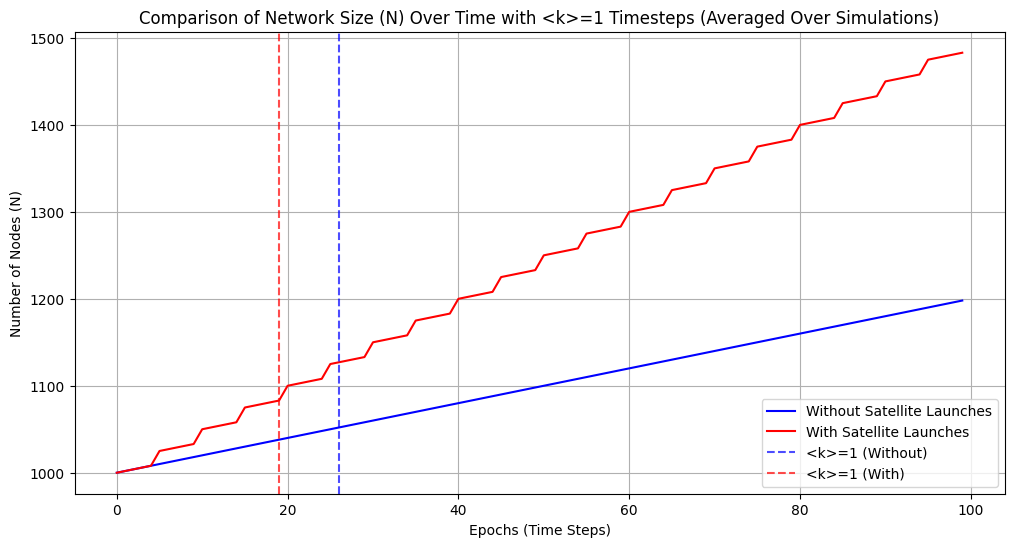

In [18]:
import matplotlib.pyplot as plt
from network.network import dynamic_network_model
import networkx as nx
import numpy as np
from scipy.stats import mannwhitneyu

# Parameters
N = 1000  # Initial number of nodes
P = 0.0008  # Collision probability
plow = 0.01  # Probability of generating new fragments
new_fragments_per_collision = 2  # Debris per collision
iterations = 100  # Number of time steps
launch_freq = 5  # Launch satellites every 5 time steps
nr_sat_launches = 15  # Number of satellites launched per launch
num_simulations = 50  # Number of simulations to average

# Initialize arrays to store results across simulations
nodes_over_time_without_all = []
nodes_over_time_with_all = []
avg_degrees_without_all = []
avg_degrees_with_all = []
gc_proportions_without_all = []
gc_proportions_with_all = []
k_equal_1_timesteps_without = []
k_equal_1_timesteps_with = []

# Run simulations without satellite launches
print("Running simulations WITHOUT satellite launches...")
for _ in range(num_simulations):
    G_without_sat = nx.empty_graph(N)
    avg_degrees_without, gc_proportions_without, _ = dynamic_network_model(
        G_without_sat, iterations, P, plow, new_fragments_per_collision, nr_sat_launches=0, launch_freq=launch_freq
    )
    avg_degrees_without_all.append(np.pad(avg_degrees_without, (0, iterations - len(avg_degrees_without)), constant_values=np.nan))
    gc_proportions_without_all.append(np.pad(gc_proportions_without, (0, iterations - len(gc_proportions_without)), constant_values=np.nan))
    nodes_over_time_without = [N + i * new_fragments_per_collision for i in range(iterations)]
    nodes_over_time_without_all.append(nodes_over_time_without)
    
    k_equal_1_timestep = next((i for i, k in enumerate(avg_degrees_without) if k >= 1), None)
    if k_equal_1_timestep is not None:
        k_equal_1_timesteps_without.append(k_equal_1_timestep)

# Run simulations with satellite launches
print("Running simulations WITH satellite launches...")
for _ in range(num_simulations):
    G_with_sat = nx.empty_graph(N)
    avg_degrees_with, gc_proportions_with, _ = dynamic_network_model(
        G_with_sat, iterations, P, plow, new_fragments_per_collision, nr_sat_launches, launch_freq
    )
    avg_degrees_with_all.append(np.pad(avg_degrees_with, (0, iterations - len(avg_degrees_with)), constant_values=np.nan))
    gc_proportions_with_all.append(np.pad(gc_proportions_with, (0, iterations - len(gc_proportions_with)), constant_values=np.nan))
    nodes_over_time_with = [
        N + i * new_fragments_per_collision + (i // launch_freq) * nr_sat_launches for i in range(iterations)
    ]
    nodes_over_time_with_all.append(nodes_over_time_with)
    
    k_equal_1_timestep = next((i for i, k in enumerate(avg_degrees_with) if k >= 1), None)
    if k_equal_1_timestep is not None:
        k_equal_1_timesteps_with.append(k_equal_1_timestep)

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(k_equal_1_timesteps_without, k_equal_1_timesteps_with, alternative='greater')

print("Mann-Whitney U Test Results:")
print(f"U Statistic: {stat}")
print(f"P-Value: {p_value}")

# Compute averages across simulations
avg_nodes_without = np.nanmean(nodes_over_time_without_all, axis=0)
avg_nodes_with = np.nanmean(nodes_over_time_with_all, axis=0)
avg_k_without = np.nanmean(avg_degrees_without_all, axis=0)
avg_k_with = np.nanmean(avg_degrees_with_all, axis=0)
avg_gc_proportions_without = np.nanmean(gc_proportions_without_all, axis=0)
avg_gc_proportions_with = np.nanmean(gc_proportions_with_all, axis=0)

# Plot the results for network size over time
plt.figure(figsize=(12, 6))

# Plot nodes over time for both models
plt.plot(range(iterations), avg_nodes_without, label="Without Satellite Launches", color="blue")
plt.plot(range(iterations), avg_nodes_with, label="With Satellite Launches", color="red")

# Add horizontal lines for <k> = 1 timesteps
k_equal_1_timestep_without = next((i for i, k in enumerate(avg_k_without) if k >= 1), None)
k_equal_1_timestep_with = next((i for i, k in enumerate(avg_k_with) if k >= 1), None)
if k_equal_1_timestep_without is not None:
    plt.axvline(x=k_equal_1_timestep_without, color="blue", linestyle="--", alpha=0.7, label="<k>=1 (Without)")
if k_equal_1_timestep_with is not None:
    plt.axvline(x=k_equal_1_timestep_with, color="red", linestyle="--", alpha=0.7, label="<k>=1 (With)")

# Add labels, legend, and title
plt.title("Comparison of Network Size (N) Over Time with <k>=1 Timesteps (Averaged Over Simulations)")
plt.xlabel("Epochs (Time Steps)")
plt.ylabel("Number of Nodes (N)")
plt.legend()
plt.grid(True)
plt.show()


Running simulations WITHOUT satellite launches...
In time step 0, 0 new satellites were launched, total nodes = 1005 

In time step 5, 0 new satellites were launched, total nodes = 1045 

In time step 10, 0 new satellites were launched, total nodes = 1084 

In time step 15, 0 new satellites were launched, total nodes = 1132 

In time step 20, 0 new satellites were launched, total nodes = 1185 

In time step 25, 0 new satellites were launched, total nodes = 1239 

In time step 30, 0 new satellites were launched, total nodes = 1298 

In time step 35, 0 new satellites were launched, total nodes = 1387 

In time step 40, 0 new satellites were launched, total nodes = 1463 

In time step 45, 0 new satellites were launched, total nodes = 1540 

In time step 50, 0 new satellites were launched, total nodes = 1624 

In time step 55, 0 new satellites were launched, total nodes = 1727 

In time step 60, 0 new satellites were launched, total nodes = 1831 

In time step 65, 0 new satellites were lau

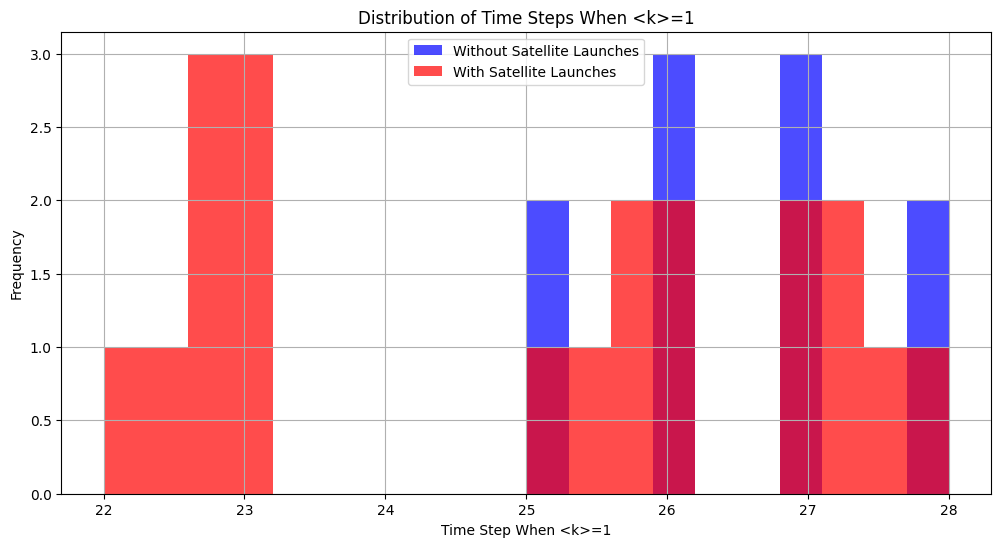

In [17]:
import matplotlib.pyplot as plt
from network.network import dynamic_network_model
import networkx as nx
import numpy as np
from scipy.stats import mannwhitneyu

# Parameters
N = 1000  # Initial number of nodes
P = 0.0008  # Collision probability
plow = 0.01  # Probability of generating new fragments
new_fragments_per_collision = 2  # Debris per collision
iterations = 100  # Number of time steps
launch_freq = 5  # Launch satellites every 5 time steps
nr_sat_launches = 2  # Number of satellites launched per launch
num_simulations = 10  # Number of simulations to average

# Initialize arrays to store results across simulations
nodes_over_time_without_all = []
nodes_over_time_with_all = []
avg_degrees_without_all = []
avg_degrees_with_all = []
gc_proportions_without_all = []
gc_proportions_with_all = []
k_equal_1_timesteps_without = []
k_equal_1_timesteps_with = []

# Run simulations without satellite launches
print("Running simulations WITHOUT satellite launches...")
for _ in range(num_simulations):
    G_without_sat = nx.empty_graph(N)
    avg_degrees_without, gc_proportions_without, _ = dynamic_network_model(
        G_without_sat, iterations, P, plow, new_fragments_per_collision, nr_sat_launches=0, launch_freq=launch_freq
    )
    avg_degrees_without_all.append(np.pad(avg_degrees_without, (0, iterations - len(avg_degrees_without)), constant_values=np.nan))
    gc_proportions_without_all.append(np.pad(gc_proportions_without, (0, iterations - len(gc_proportions_without)), constant_values=np.nan))
    nodes_over_time_without = [N + i * new_fragments_per_collision for i in range(iterations)]
    nodes_over_time_without_all.append(nodes_over_time_without)
    
    k_equal_1_timestep = next((i for i, k in enumerate(avg_degrees_without) if k >= 1), None)
    if k_equal_1_timestep is not None:
        k_equal_1_timesteps_without.append(k_equal_1_timestep)

# Run simulations with satellite launches
print("Running simulations WITH satellite launches...")
for _ in range(num_simulations):
    G_with_sat = nx.empty_graph(N)
    avg_degrees_with, gc_proportions_with, _ = dynamic_network_model(
        G_with_sat, iterations, P, plow, new_fragments_per_collision, nr_sat_launches, launch_freq
    )
    avg_degrees_with_all.append(np.pad(avg_degrees_with, (0, iterations - len(avg_degrees_with)), constant_values=np.nan))
    gc_proportions_with_all.append(np.pad(gc_proportions_with, (0, iterations - len(gc_proportions_with)), constant_values=np.nan))
    nodes_over_time_with = [
        N + i * new_fragments_per_collision + (i // launch_freq) * nr_sat_launches for i in range(iterations)
    ]
    nodes_over_time_with_all.append(nodes_over_time_with)
    
    k_equal_1_timestep = next((i for i, k in enumerate(avg_degrees_with) if k >= 1), None)
    if k_equal_1_timestep is not None:
        k_equal_1_timesteps_with.append(k_equal_1_timestep)

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(k_equal_1_timesteps_without, k_equal_1_timesteps_with, alternative='greater')

print("Mann-Whitney U Test Results:")
print(f"U Statistic: {stat}")
print(f"P-Value: {p_value}")

# Compute U statistic range
n1, n2 = len(k_equal_1_timesteps_without), len(k_equal_1_timesteps_with)
U_min, U_max = 0, n1 * n2
print(f"U Statistic Range: {U_min} to {U_max}")

# Visualize distributions
plt.figure(figsize=(12, 6))
plt.hist(k_equal_1_timesteps_without, alpha=0.7, label="Without Satellite Launches", color="blue")
plt.hist(k_equal_1_timesteps_with, alpha=0.7, label="With Satellite Launches", color="red")
plt.xlabel("Time Step When <k>=1")
plt.ylabel("Frequency")
plt.title("Distribution of Time Steps When <k>=1")
plt.legend()
plt.grid(True)
plt.show()


Running simulations WITHOUT satellite launches...
In time step 0, 0 new satellites were launched, total nodes = 1003 

In time step 5, 0 new satellites were launched, total nodes = 1042 

In time step 10, 0 new satellites were launched, total nodes = 1085 

In time step 15, 0 new satellites were launched, total nodes = 1123 

In time step 20, 0 new satellites were launched, total nodes = 1184 

In time step 25, 0 new satellites were launched, total nodes = 1244 

In time step 30, 0 new satellites were launched, total nodes = 1317 

In time step 35, 0 new satellites were launched, total nodes = 1400 

In time step 40, 0 new satellites were launched, total nodes = 1478 

In time step 45, 0 new satellites were launched, total nodes = 1572 

In time step 50, 0 new satellites were launched, total nodes = 1703 

In time step 55, 0 new satellites were launched, total nodes = 1826 

In time step 60, 0 new satellites were launched, total nodes = 1945 

In time step 65, 0 new satellites were lau

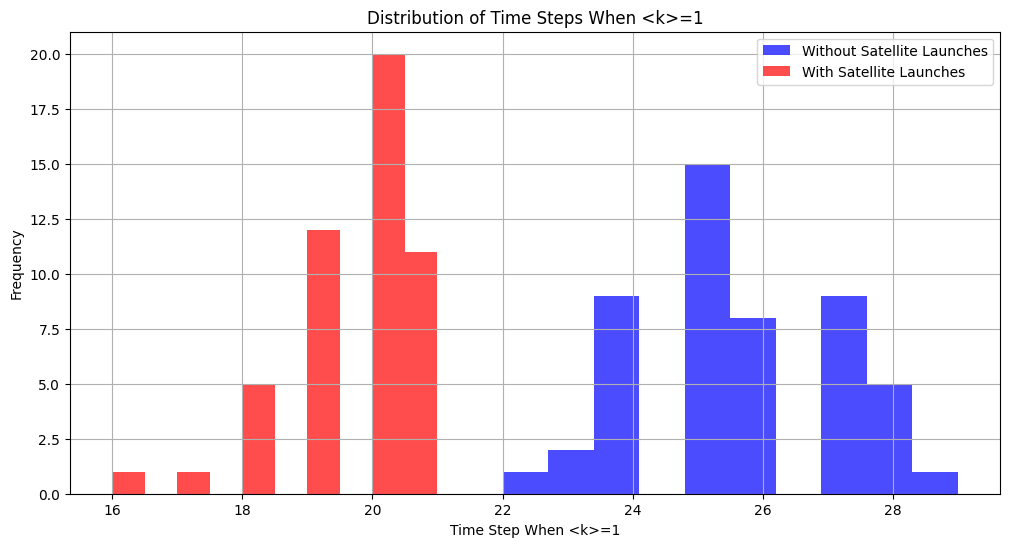

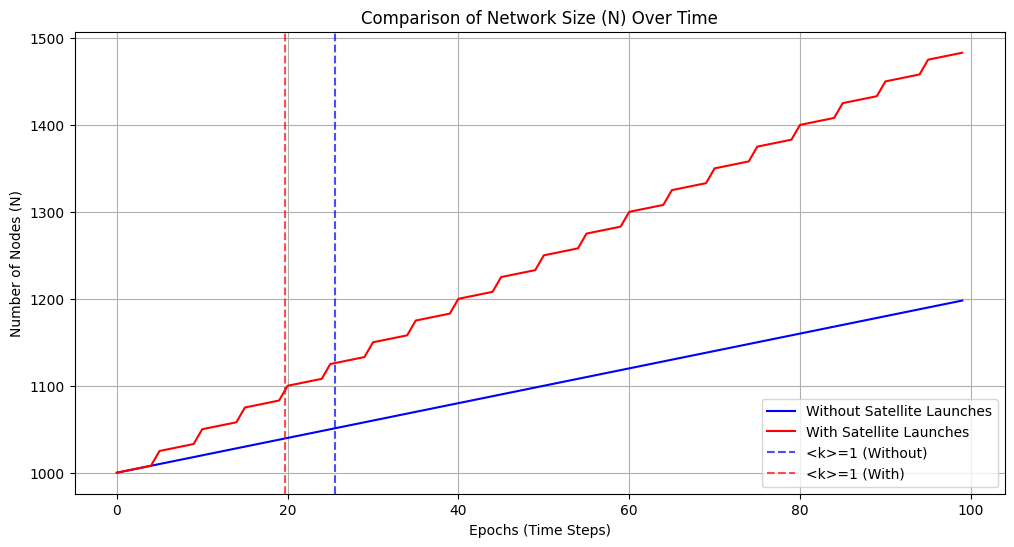

/var/folders/sq/c9xq2zk97n3cf_nqf5x49c0w0000gn/T/ipykernel_43214/2406186153.py:104: RuntimeWarning: Mean of empty slice
  plt.plot(range(iterations), np.nanmean(gc_proportions_without_all, axis=0), label="Without Satellite Launches", color="blue")
/var/folders/sq/c9xq2zk97n3cf_nqf5x49c0w0000gn/T/ipykernel_43214/2406186153.py:105: RuntimeWarning: Mean of empty slice
  plt.plot(range(iterations), np.nanmean(gc_proportions_with_all, axis=0), label="With Satellite Launches", color="red")


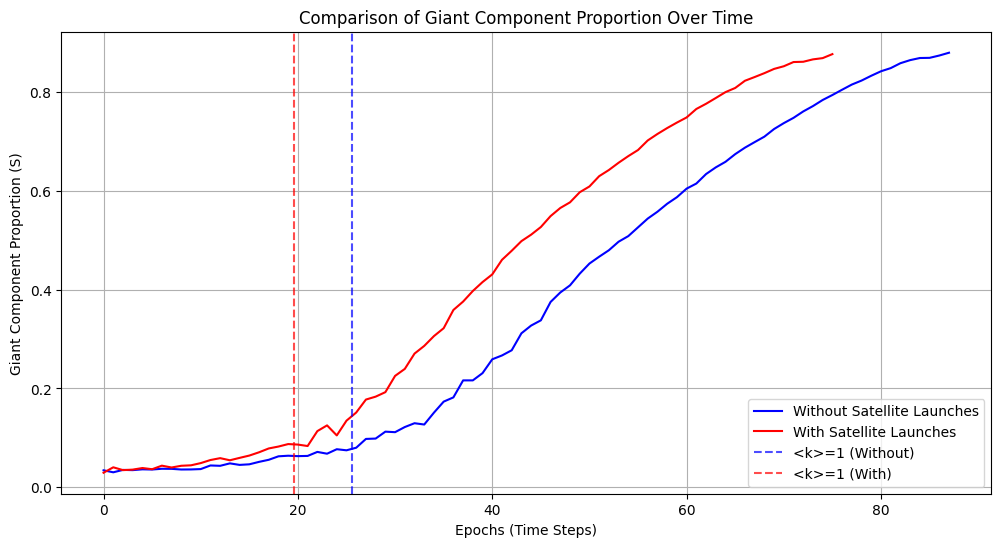

In [21]:
import matplotlib.pyplot as plt
from network.network import dynamic_network_model
import networkx as nx
import numpy as np
from scipy.stats import mannwhitneyu

# Parameters
N = 1000  # Initial number of nodes
P = 0.0008  # Collision probability
plow = 0.01  # Probability of generating new fragments
new_fragments_per_collision = 2  # Debris per collision
iterations = 100  # Number of time steps
launch_freq = 5  # Launch satellites every 5 time steps
nr_sat_launches = 15  # Number of satellites launched per launch
num_simulations = 50  # Number of simulations to average

# Initialize arrays to store results across simulations
nodes_over_time_without_all = []
nodes_over_time_with_all = []
avg_degrees_without_all = []
avg_degrees_with_all = []
gc_proportions_without_all = []
gc_proportions_with_all = []
k_equal_1_timesteps_without = []
k_equal_1_timesteps_with = []

# Run simulations without satellite launches
print("Running simulations WITHOUT satellite launches...")
for _ in range(num_simulations):
    G_without_sat = nx.empty_graph(N)
    avg_degrees_without, gc_proportions_without, _ = dynamic_network_model(
        G_without_sat, iterations, P, plow, new_fragments_per_collision, nr_sat_launches=0, launch_freq=launch_freq
    )
    avg_degrees_without_all.append(np.pad(avg_degrees_without, (0, iterations - len(avg_degrees_without)), constant_values=np.nan))
    gc_proportions_without_all.append(np.pad(gc_proportions_without, (0, iterations - len(gc_proportions_without)), constant_values=np.nan))
    nodes_over_time_without = [N + i * new_fragments_per_collision for i in range(iterations)]
    nodes_over_time_without_all.append(nodes_over_time_without)
    
    k_equal_1_timestep = next((i for i, k in enumerate(avg_degrees_without) if k >= 1), None)
    if k_equal_1_timestep is not None:
        k_equal_1_timesteps_without.append(k_equal_1_timestep)

# Run simulations with satellite launches
print("Running simulations WITH satellite launches...")
for _ in range(num_simulations):
    G_with_sat = nx.empty_graph(N)
    avg_degrees_with, gc_proportions_with, _ = dynamic_network_model(
        G_with_sat, iterations, P, plow, new_fragments_per_collision, nr_sat_launches, launch_freq
    )
    avg_degrees_with_all.append(np.pad(avg_degrees_with, (0, iterations - len(avg_degrees_with)), constant_values=np.nan))
    gc_proportions_with_all.append(np.pad(gc_proportions_with, (0, iterations - len(gc_proportions_with)), constant_values=np.nan))
    nodes_over_time_with = [
        N + i * new_fragments_per_collision + (i // launch_freq) * nr_sat_launches for i in range(iterations)
    ]
    nodes_over_time_with_all.append(nodes_over_time_with)
    
    k_equal_1_timestep = next((i for i, k in enumerate(avg_degrees_with) if k >= 1), None)
    if k_equal_1_timestep is not None:
        k_equal_1_timesteps_with.append(k_equal_1_timestep)

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(k_equal_1_timesteps_without, k_equal_1_timesteps_with, alternative='greater')

print("Mann-Whitney U Test Results:")
print(f"U Statistic: {stat}")
print(f"P-Value: {p_value}")

# Compute U statistic range
n1, n2 = len(k_equal_1_timesteps_without), len(k_equal_1_timesteps_with)
U_min, U_max = 0, n1 * n2
print(f"U Statistic Range: {U_min} to {U_max}")

# Plot statistical frequency distribution
plt.figure(figsize=(12, 6))
plt.hist(k_equal_1_timesteps_without, alpha=0.7, label="Without Satellite Launches", color="blue", bins=10)
plt.hist(k_equal_1_timesteps_with, alpha=0.7, label="With Satellite Launches", color="red", bins=10)
plt.xlabel("Time Step When <k>=1")
plt.ylabel("Frequency")
plt.title("Distribution of Time Steps When <k>=1")
plt.legend()
plt.grid(True)
plt.show()

# Plot the results for network size over time
plt.figure(figsize=(12, 6))
plt.plot(range(iterations), np.nanmean(nodes_over_time_without_all, axis=0), label="Without Satellite Launches", color="blue")
plt.plot(range(iterations), np.nanmean(nodes_over_time_with_all, axis=0), label="With Satellite Launches", color="red")

# Add horizontal lines for <k>=1 timesteps
if k_equal_1_timesteps_without:
    plt.axvline(x=np.mean(k_equal_1_timesteps_without), color="blue", linestyle="--", alpha=0.7, label="<k>=1 (Without)")
if k_equal_1_timesteps_with:
    plt.axvline(x=np.mean(k_equal_1_timesteps_with), color="red", linestyle="--", alpha=0.7, label="<k>=1 (With)")

plt.xlabel("Epochs (Time Steps)")
plt.ylabel("Number of Nodes (N)")
plt.title("Comparison of Network Size (N) Over Time")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot the results for giant component proportion over time
plt.figure(figsize=(12, 6))
plt.plot(range(iterations), np.nanmean(gc_proportions_without_all, axis=0), label="Without Satellite Launches", color="blue")
plt.plot(range(iterations), np.nanmean(gc_proportions_with_all, axis=0), label="With Satellite Launches", color="red")

# Add horizontal lines for <k>=1 timesteps
if k_equal_1_timesteps_without:
    plt.axvline(x=np.mean(k_equal_1_timesteps_without), color="blue", linestyle="--", alpha=0.7, label="<k>=1 (Without)")
if k_equal_1_timesteps_with:
    plt.axvline(x=np.mean(k_equal_1_timesteps_with), color="red", linestyle="--", alpha=0.7, label="<k>=1 (With)")

plt.xlabel("Epochs (Time Steps)")
plt.ylabel("Giant Component Proportion (S)")
plt.title("Comparison of Giant Component Proportion Over Time")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()